## Visualizing the geometry of "factual"representation

### Preprocessing

#### Prepare the data

In [1]:
import numpy as np

# Replace the file path with the actual path to your .npy file
layer_wise = np.load('new_features/llama_xsum_layer_wise.npy')
head_wise = np.load('new_features/llama_xsum_head_wise.npy')
labels = np.load('new_features/llama_xsum_labels.npy')

In [2]:
print("Layer wise shape:",layer_wise.shape)
print("Head wise shape:",head_wise.shape)

Layer wise shape: (1700, 33, 4096)
Head wise shape: (1700, 32, 32, 128)


In [4]:
print(layer_wise[0])

[[ 1.0986328e-02  9.8876953e-03 -5.0964355e-03 ...  2.5177002e-03
   7.7056885e-04 -5.0048828e-03]
 [-3.1772193e-02  3.7786245e-02  1.6111473e-02 ... -1.7747417e-02
  -7.2661284e-03 -4.7669867e-03]
 [-2.4470404e-02  4.7700040e-02  2.6577996e-02 ...  2.4790451e-02
  -8.9212880e-04  1.4333914e-02]
 ...
 [ 1.8766255e+00 -1.4705498e+00 -1.5924569e+00 ... -2.1516044e+00
  -8.6084032e-01  7.3795950e-01]
 [ 1.8522712e+00 -1.5713822e+00 -1.5482857e+00 ... -2.0374637e+00
  -7.3917115e-01  4.6739173e-01]
 [ 2.4094015e-01 -2.4229383e-01 -2.0194381e-01 ... -2.3527069e-01
  -8.2544357e-02  3.7369158e-02]]


In [5]:
print(labels[:20])

[1.         5.         5.         5.         5.         5.
 4.66666667 5.         5.         5.         5.         5.
 5.         3.         5.         5.         2.33333333 2.
 5.         5.        ]


#### Update to binary labels

In [6]:
threshold = 3.5
labels = (labels >= threshold).astype(int)

In [7]:
# Check updated labels
print("Updated binary labels:", labels)

# Check label distribution
unique, counts = np.unique(labels, return_counts=True)
print("Binary label distribution:", dict(zip(unique, counts)))

Updated binary labels: [0 1 1 ... 1 1 1]
Binary label distribution: {np.int64(0): np.int64(156), np.int64(1): np.int64(1544)}


In [8]:
assert head_wise.shape[0] == labels.shape[0]
assert layer_wise.shape[0] == labels.shape[0]

# Example: Selecting only factual (label=1) and non-factual (label=0) samples
factual_indices = labels == 1
non_factual_indices = labels == 0

head_wise_factual = head_wise[factual_indices]
layer_wise_factual = layer_wise[factual_indices]

head_wise_non_factual = head_wise[non_factual_indices]
layer_wise_non_factual = layer_wise[non_factual_indices]

#### Shape of the activations

In [9]:
print("Head-wise factual activations shape:", head_wise_factual.shape)
print("Layer-wise factual activations shape:", layer_wise_factual.shape)
print("Head-wise non-factual activations shape:", head_wise_non_factual.shape)
print("Layer-wise non-factual activations shape:", layer_wise_non_factual.shape)

Head-wise factual activations shape: (1544, 32, 32, 128)
Layer-wise factual activations shape: (1544, 33, 4096)
Head-wise non-factual activations shape: (156, 32, 32, 128)
Layer-wise non-factual activations shape: (156, 33, 4096)


In [10]:
print("Label counts:", np.unique(labels, return_counts=True))

Label counts: (array([0, 1]), array([ 156, 1544]))


#### Quantify the data: seems like it has imbalance

In [11]:
from collections import Counter
print("Class distribution:", Counter(labels))

Class distribution: Counter({np.int64(1): 1544, np.int64(0): 156})


## Calculating mean and difference for each layer

In [11]:
import numpy as np

layer_wise_fmean = np.mean(layer_wise_factual, axis = 0)
layer_wise_nfmean =np.mean(layer_wise_non_factual, axis = 0)

difference = layer_wise_fmean - layer_wise_nfmean
print(difference.shape)

import numpy as np

# Compute the L2 norm (magnitude) for each layer
layerwise_magnitude = np.linalg.norm(difference, axis=1)  # Shape: (num_layers,)

# Find the index of the layer with the largest difference
most_influential_layer = np.argmax(layerwise_magnitude)
print(f"The most influential layer is layer {most_influential_layer} with a magnitude of {layerwise_magnitude[most_influential_layer]}")



(33, 4096)
The most influential layer is layer 23 with a magnitude of 88.98592376708984


In [12]:
# Sort the magnitudes in descending order and get the indices of the top 10 layers
top_10_layers_indices = np.argsort(layerwise_magnitude)[::-1][:10]  # Sort in descending order

# Print the top 10 layers with their magnitudes
print("Top 10 Layers with Highest Magnitude of Difference:")
for i in top_10_layers_indices:
    print(f"Layer {i}: Magnitude = {layerwise_magnitude[i]}")


Top 10 Layers with Highest Magnitude of Difference:
Layer 23: Magnitude = 88.98592376708984
Layer 24: Magnitude = 87.39366912841797
Layer 25: Magnitude = 80.99421691894531
Layer 26: Magnitude = 80.72781372070312
Layer 27: Magnitude = 80.21659851074219
Layer 28: Magnitude = 79.24812316894531
Layer 29: Magnitude = 78.71986389160156
Layer 31: Magnitude = 77.90784454345703
Layer 30: Magnitude = 77.70024871826172
Layer 5: Magnitude = 24.434221267700195


### Plotting influence of layers in  activation

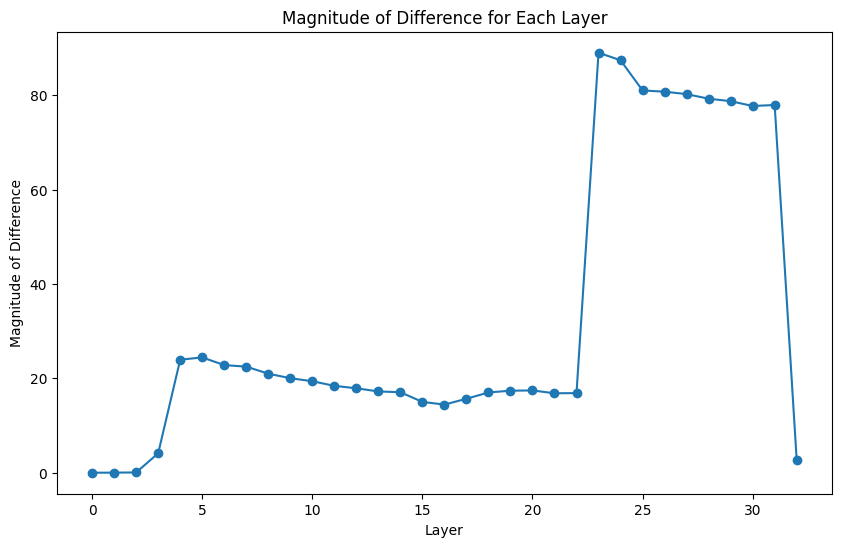

In [13]:
import matplotlib.pyplot as plt

# Plot the layerwise magnitudes
plt.figure(figsize=(10, 6))
plt.plot(layerwise_magnitude, marker='o')
plt.xlabel("Layer")
plt.ylabel("Magnitude of Difference")
plt.title("Magnitude of Difference for Each Layer")
plt.show()


## Calculate the mean and difference for all heads in each layer

In [12]:
import numpy as np

# Compute mean activations per head
mean_factual = np.mean((head_wise_factual), axis=(0, 3))  # Shape: (32, 32)
mean_non_factual = np.mean((head_wise_non_factual), axis=(0, 3))  # Shape: (32, 32)


# Compute the absolute mean magnitude difference per head
mean_magnitude_diff = (mean_factual - mean_non_factual)  # Shape: (32, 32) -> (layers, heads)

print(mean_magnitude_diff.shape)

(32, 32)


## Sort the heads based on difference

In [13]:
# Get sorted head indices for each layer (sorting within each row)
sorted_heads = np.argsort(-mean_magnitude_diff, axis=1)  # Sorting in descending order
sorted_mean_magnitude_diff = np.take_along_axis(mean_magnitude_diff, sorted_heads, axis=1)  # Shape: (32, 32)


In [32]:
# Assuming `mean_magnitude_diff` is your (32, 32) array of magnitude differences

top_k = 30  # Number of top heads
top_k_layers_heads = []  # To store layer, head indices
top_k_magnitudes = []  # To store the corresponding maximum magnitudes

# Iterate over each layer and each head to find the max magnitude difference
for layer in range(mean_magnitude_diff.shape[0]):
    for head in range(mean_magnitude_diff.shape[1]):
        magnitude = mean_magnitude_diff[layer, head]  # Get the magnitude for each layer-head pair
        top_k_layers_heads.append((layer, head))
        top_k_magnitudes.append(magnitude)

# Sort the heads based on the magnitude in descending order
sorted_indices = np.argsort(top_k_magnitudes)[::-1][:top_k]

# Print the top k heads with their layers and the maximum magnitude
print("Top K Heads and Magnitudes (Layer, Head, Magnitude):")
for i in sorted_indices:
    layer, head = top_k_layers_heads[i]
    magnitude = top_k_magnitudes[i]
    print(f"Layer {layer}, Head {head}, Magnitude {magnitude:.4f}")


Top K Heads and Magnitudes (Layer, Head, Magnitude):
Layer 22, Head 3, Magnitude 0.2340
Layer 3, Head 22, Magnitude 0.0285
Layer 22, Head 25, Magnitude 0.0238
Layer 3, Head 3, Magnitude 0.0185
Layer 3, Head 11, Magnitude 0.0169
Layer 5, Head 23, Magnitude 0.0144
Layer 3, Head 28, Magnitude 0.0138
Layer 22, Head 7, Magnitude 0.0137
Layer 6, Head 27, Magnitude 0.0120
Layer 3, Head 27, Magnitude 0.0119
Layer 8, Head 3, Magnitude 0.0112
Layer 3, Head 8, Magnitude 0.0109
Layer 4, Head 1, Magnitude 0.0107
Layer 6, Head 20, Magnitude 0.0104
Layer 16, Head 25, Magnitude 0.0102
Layer 3, Head 13, Magnitude 0.0100
Layer 3, Head 6, Magnitude 0.0096
Layer 4, Head 14, Magnitude 0.0096
Layer 16, Head 22, Magnitude 0.0092
Layer 3, Head 30, Magnitude 0.0090
Layer 5, Head 30, Magnitude 0.0085
Layer 5, Head 16, Magnitude 0.0085
Layer 6, Head 28, Magnitude 0.0077
Layer 4, Head 24, Magnitude 0.0077
Layer 3, Head 20, Magnitude 0.0077
Layer 5, Head 13, Magnitude 0.0075
Layer 19, Head 22, Magnitude 0.0068
Lay

## Plot heatmap where y axis is 32 layers and x axis is sorted heads

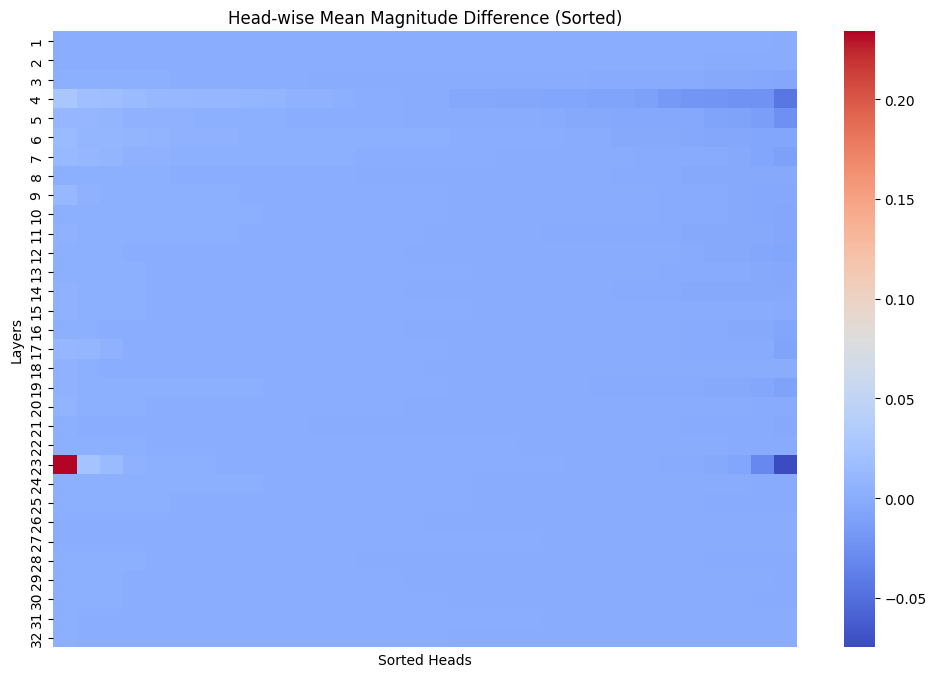

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(sorted_mean_magnitude_diff, cmap="coolwarm", xticklabels=False, yticklabels=np.arange(1, 33))
plt.xlabel("Sorted Heads")
plt.ylabel("Layers")
plt.title("Head-wise Mean Magnitude Difference (Sorted)")
plt.show()

## Train a linear classifier using activations from only those heads and layers with hugh magnitude difference

### Select most important heads & layers

In [34]:
import numpy as np

# Assume `mean_differences` is (num_layers, num_heads) from your analysis
num_layers, num_heads = mean_magnitude_diff.shape

print("Shape of mean_magnitude_diff:", mean_magnitude_diff.shape)  
# Should print: (32, 32)

top_k = 20  # Adjust based on how many heads you want to use

flattened = mean_magnitude_diff.flatten()
sorted_indices = np.argsort(flattened)[::-1][:top_k]  # Get top_k indices

print("Max selected index:", max(sorted_indices))  # Should be ≤ 1023
print("Total possible indices:", num_layers * num_heads)  # Should be 1024



Shape of mean_magnitude_diff: (32, 32)
Max selected index: 729
Total possible indices: 1024


In [35]:
selected_layers_heads = []
for idx in sorted_indices:
    layer, head = divmod(idx, num_heads)
    if layer >= num_layers:
        print(f"ERROR: Flattened index {idx} maps to invalid layer {layer}")
    selected_layers_heads.append((layer, head))

print("Selected (layer, head) pairs:", selected_layers_heads)


Selected (layer, head) pairs: [(np.int64(22), np.int64(3)), (np.int64(3), np.int64(22)), (np.int64(22), np.int64(25)), (np.int64(3), np.int64(3)), (np.int64(3), np.int64(11)), (np.int64(5), np.int64(23)), (np.int64(3), np.int64(28)), (np.int64(22), np.int64(7)), (np.int64(6), np.int64(27)), (np.int64(3), np.int64(27)), (np.int64(8), np.int64(3)), (np.int64(3), np.int64(8)), (np.int64(4), np.int64(1)), (np.int64(6), np.int64(20)), (np.int64(16), np.int64(25)), (np.int64(3), np.int64(13)), (np.int64(3), np.int64(6)), (np.int64(4), np.int64(14)), (np.int64(16), np.int64(22)), (np.int64(3), np.int64(30))]


### Extract features for classifier

In [36]:
# Ensure you are indexing correctly
selected_head_indices = []
for layer, head in selected_layers_heads:
    index = layer * num_heads + head  # Flattened index
    selected_head_indices.append(index)

print(f"Selected head indices for classification: {selected_head_indices}")


Selected head indices for classification: [np.int64(707), np.int64(118), np.int64(729), np.int64(99), np.int64(107), np.int64(183), np.int64(124), np.int64(711), np.int64(219), np.int64(123), np.int64(259), np.int64(104), np.int64(129), np.int64(212), np.int64(537), np.int64(109), np.int64(102), np.int64(142), np.int64(534), np.int64(126)]


In [37]:
X_selected = []  # Feature matrix
y_labels = labels  # Ensure you have labels (factual = 1, non-factual = 0)

for sample in range(len(head_wise)):
    features = []
    for layer, head in selected_layers_heads:
        activation = head_wise[sample, layer, head, :]
        #print(f"Sample {sample}, Layer {layer}, Head {head}, Activation shape: {activation.shape}")
        features.append(activation)
    concatenated_features = np.concatenate(features)
    print(f"Concatenated features shape for sample {sample}: {concatenated_features.shape}")
    X_selected.append(concatenated_features)  # Flatten and store


X_selected = np.array(X_selected)  # Shape: (num_samples, selected_heads * num_features)


Concatenated features shape for sample 0: (2560,)
Concatenated features shape for sample 1: (2560,)
Concatenated features shape for sample 2: (2560,)
Concatenated features shape for sample 3: (2560,)
Concatenated features shape for sample 4: (2560,)
Concatenated features shape for sample 5: (2560,)
Concatenated features shape for sample 6: (2560,)
Concatenated features shape for sample 7: (2560,)
Concatenated features shape for sample 8: (2560,)
Concatenated features shape for sample 9: (2560,)
Concatenated features shape for sample 10: (2560,)
Concatenated features shape for sample 11: (2560,)
Concatenated features shape for sample 12: (2560,)
Concatenated features shape for sample 13: (2560,)
Concatenated features shape for sample 14: (2560,)
Concatenated features shape for sample 15: (2560,)
Concatenated features shape for sample 16: (2560,)
Concatenated features shape for sample 17: (2560,)
Concatenated features shape for sample 18: (2560,)
Concatenated features shape for sample 19

### Train a linear classifier: logistic regression

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_labels, test_size=0.20, random_state=42)

# Train classifier
clf = LogisticRegression(random_state= 42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9058823529411765


/home/trina/miniconda3/envs/pyvene/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


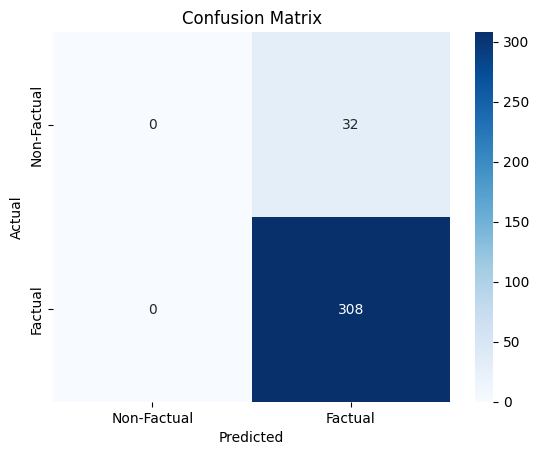

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Factual", "Factual"], yticklabels=["Non-Factual", "Factual"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [40]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=["Non-Factual", "Factual"]))


              precision    recall  f1-score   support

 Non-Factual       0.00      0.00      0.00        32
     Factual       0.91      1.00      0.95       308

    accuracy                           0.91       340
   macro avg       0.45      0.50      0.48       340
weighted avg       0.82      0.91      0.86       340



/home/trina/miniconda3/envs/pyvene/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/trina/miniconda3/envs/pyvene/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/trina/miniconda3/envs/pyvene/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

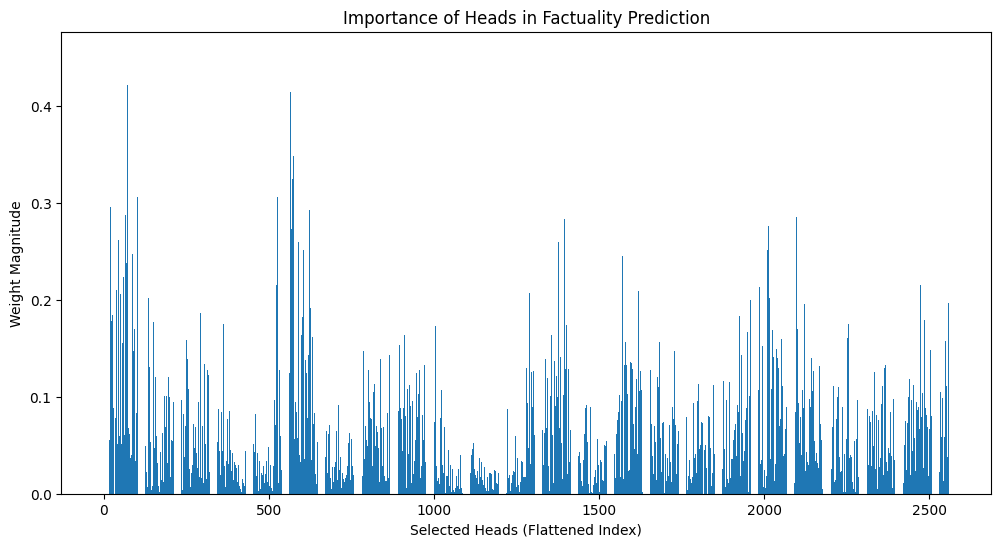

In [33]:
import matplotlib.pyplot as plt

# Get weights from trained classifier
weights = np.abs(clf.coef_[0])  # Absolute value for importance

# Plot importance of each selected head
plt.figure(figsize=(12, 6))
plt.bar(range(len(weights)), weights)
plt.xlabel("Selected Heads (Flattened Index)")
plt.ylabel("Weight Magnitude")
plt.title("Importance of Heads in Factuality Prediction")
plt.show()


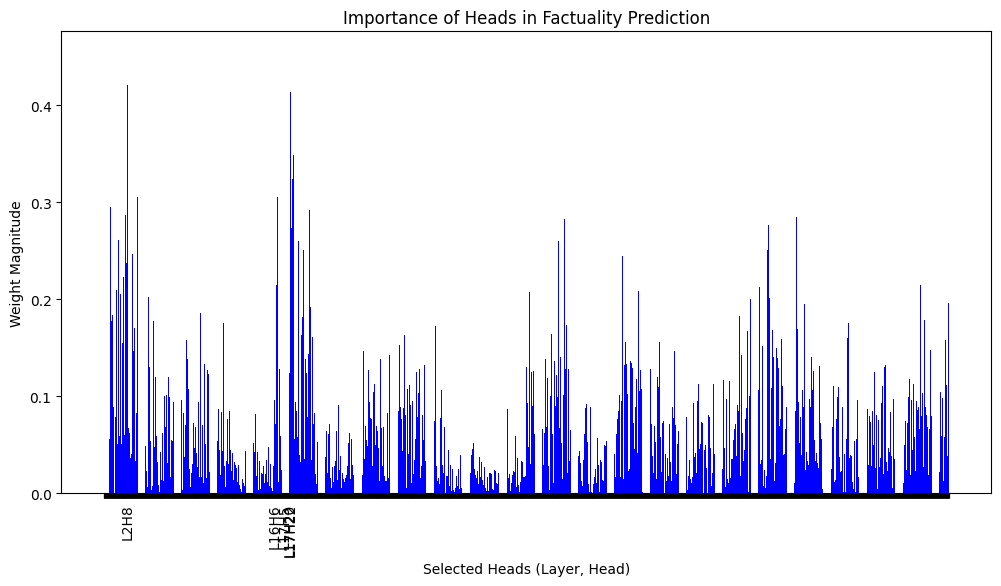

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Get weights from trained classifier
weights = np.abs(clf.coef_[0])  # Absolute value for importance

# Convert flattened indices back to (layer, head)
num_heads = 32  # Fixed number of heads per layer
layer_indices = [idx // num_heads for idx in range(len(weights))]  # Compute layer index
head_indices = [idx % num_heads for idx in range(len(weights))]    # Compute head index

# Create (Layer, Head) labels for x-axis
head_labels = [f"L{layer}H{head}" for layer, head in zip(layer_indices, head_indices)]

# Select **Top N Important Heads** to Label
top_n = 5  # Change this to control how many labels are displayed
top_indices = np.argsort(weights)[-top_n:]  # Get indices of top N heads with highest weight

# Create x-axis labels: Only show for top N important heads
x_labels = [""] * len(weights)  # Start with empty labels
for idx in top_indices:
    x_labels[idx] = head_labels[idx]  # Assign label only for top N

# Plot importance of each selected head with sparse labels
plt.figure(figsize=(12, 6))
plt.bar(range(len(weights)), weights, color="blue")

# Apply selective labels
plt.xticks(ticks=np.arange(len(weights)), labels=x_labels, rotation=90)  # Rotate for readability
plt.xlabel("Selected Heads (Layer, Head)")
plt.ylabel("Weight Magnitude")
plt.title("Importance of Heads in Factuality Prediction")
plt.show()


In [39]:
sorted_indices = np.argsort(weights)[-20:]  # Get indices of top 20 highest-weight heads
print("Top heads according to classifier weights:")
for idx in sorted_indices:
    layer = idx // num_heads
    head = idx % num_heads
    print(f"Layer {layer}, Head {head}, Weight: {weights[idx]}")


Top heads according to classifier weights:
Layer 1, Head 20, Weight: 0.2985961510005332
Layer 0, Head 29, Weight: 0.2997614082137524
Layer 3, Head 6, Weight: 0.30540135330192314
Layer 16, Head 14, Weight: 0.3058141340697695
Layer 5, Head 17, Weight: 0.309633234640624
Layer 16, Head 24, Weight: 0.31850679625144357
Layer 77, Head 10, Weight: 0.32201178504364397
Layer 2, Head 7, Weight: 0.32334131375017655
Layer 17, Head 28, Weight: 0.3239068366909092
Layer 17, Head 31, Weight: 0.34836974715208524
Layer 3, Head 16, Weight: 0.350684406492424
Layer 17, Head 18, Weight: 0.35558506142126955
Layer 3, Head 13, Weight: 0.3556420350007604
Layer 18, Head 6, Weight: 0.3727573589646116
Layer 17, Head 10, Weight: 0.38892137075645233
Layer 17, Head 5, Weight: 0.39518692357205737
Layer 16, Head 6, Weight: 0.4070869854529
Layer 17, Head 22, Weight: 0.4137553198687637
Layer 2, Head 8, Weight: 0.42088265486200266
Layer 17, Head 20, Weight: 0.45352879621667447
